In [1]:
import tensorflow as tf
from tensorflow.keras.layers import concatenate, Conv2D, Input, Lambda, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
augmented_imgs_path = os.path.join('data','augmented', 'aug_imgs')
augmented_masks_path = os.path.join('data', 'augmented', 'aug_masks')

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3 #RGB

### Definition of model structure

In [4]:
#Build the model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

### Training

In [5]:
EPOCHS = 1
BATCH_SIZE = 32

6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 4.1590e-04 - loss: -1160.5215 - val_accuracy: 9.2506e-05 - val_loss: -1169.4800
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 755ms/step - accuracy: 8.6159e-05 - loss: -1183.2587
Accuracy: [-1175.458251953125, 8.417765639023855e-05]


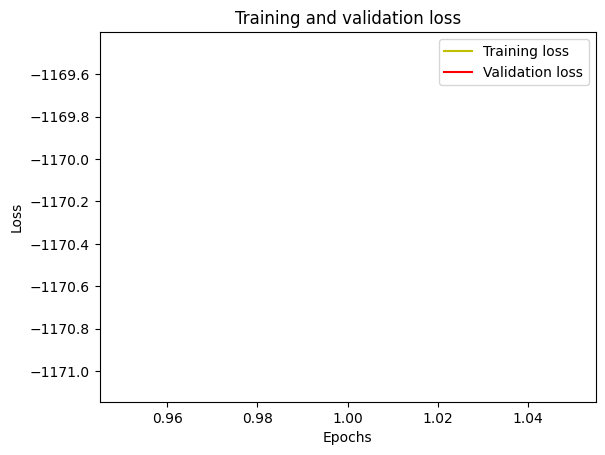

In [7]:
train_images = []
train_masks = []

for i in range(1, len(os.listdir(augmented_imgs_path))):
        img = cv2.imread(os.path.join(augmented_imgs_path, f'{i}.png'), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(augmented_masks_path, f'{i}.png'), cv2.IMREAD_GRAYSCALE)
        train_images.append(img)
        train_masks.append(mask)

#Use customary x_train and y_train variables
X = np.array(train_images)
Y = np.array(train_masks)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Compile model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#print(model.summary())

# Fit model
checkpointer = ModelCheckpoint('final_model.keras', monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history=model.fit(x_train, 
        y_train,
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        verbose=1,
        validation_split=0.2,
        callbacks=callbacks)


#plot the training and validation accuracy and loss at each epoch
accuracy = model.evaluate(x_val, y_val)

print(f'Accuracy: {accuracy}')
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
#plt.plot(epochs, accuracy, 'b', label='Accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


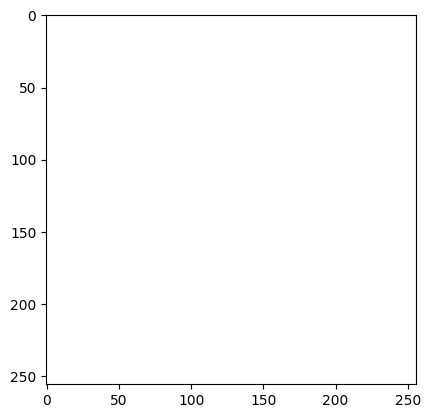

In [53]:
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread(os.path.join('data', 'originals', 'imgs', '0_RGB.png'), cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (IMG_HEIGHT, IMG_WIDTH))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')